In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time

import tensorflow as tf
import keras
from tensorflow.keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from tensorflow.keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu

In [3]:
from google.colab import drive 
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.chdir("/content/drive/My Drive/cs2")

In [4]:
'''
First we need to load the chexnet nodel (DenseNet121),
The trained weight of this model is from https://github.com/brucechou1983/CheXNet-Keras

'''
#https://github.com/antoniosehk/tCheXNet/blob/master/chexnet.py
from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
image_input= Input(shape=(224,224,3))
base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape,pooling="avg")
pred=Dense(14,"sigmoid")(base.output)

chexnet_model=Model(inputs=base.input,outputs=pred)
chexnet_model.load_weights("chexnet_weights.h5")

chexnet_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [5]:
final_chexnet_model=Model(inputs=chexnet_model.inputs,outputs=chexnet_model.layers[-2].output,name="Chexnet_model")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.692339 to fit



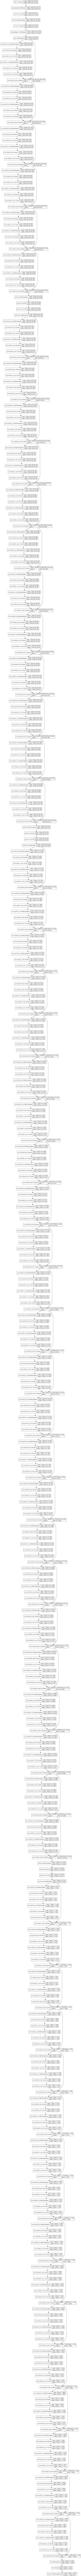

In [7]:
tf.keras.utils.plot_model(final_chexnet_model,show_shapes=True,show_layer_names=True,to_file="chex.png")

In [6]:
image_1= Input(shape=(224,224,3),name="image_1_features")
image_2= Input(shape=(224,224,3),name="image_2_features")
image_1_out=final_chexnet_model(image_1)
image_2_out=final_chexnet_model(image_2)
conc=concatenate((image_1_out,image_2_out),axis=-1,name="final_image_features")
feature_extraction_model=Model(inputs=[image_1,image_2],outputs=conc)
feature_extraction_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1_features (InputLayer)   [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
image_2_features (InputLayer)   [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Chexnet_model (Functional)      (None, 1024)         7037504     image_1_features[0][0]           
                                                                 image_2_features[0][0]           
__________________________________________________________________________________________________
final_image_features (Concatena (None, 2048)         0           Chexnet_model[0][0]   

In [7]:
Train=pd.read_csv("Train_Data.csv")
Train.head()

Person_id                              Image-1  \
0   x ray data/CXR1_1_IM-0001_0   x ray data/CXR1_1_IM-0001-3001.png   
1    x ray data/CXR10_IM-0002_0    x ray data/CXR10_IM-0002-1001.png   
2   x ray data/CXR100_IM-0002_0   x ray data/CXR100_IM-0002-1001.png   
3  x ray data/CXR1000_IM-0003_0  x ray data/CXR1000_IM-0003-1001.png   
4  x ray data/CXR1000_IM-0003_1  x ray data/CXR1000_IM-0003-1001.png   

                               Image-2  \
0   x ray data/CXR1_1_IM-0001-4001.png   
1    x ray data/CXR10_IM-0002-2001.png   
2   x ray data/CXR100_IM-0002-2001.png   
3  x ray data/CXR1000_IM-0003-2001.png   
4  x ray data/CXR1000_IM-0003-3001.png   

                                            Findings  
0  SOS the cardiac silhouette and mediastinum siz...  
1  SOS the cardiomediastinal silhouette within no...  
2  SOS both lungs are clear and epanded .  heart ...  
3  SOS there increased opacity within the right u...  
4  SOS there increased opacity within the right u...

In [10]:
'''
Obtaining the image feature for every patient using the feature extraction model which we had build earlier.
The output from this function is 2048 dimensiona vector for the x-ray set of every patient
'''

def image_feature_extraction(image1,image2):
  
 
  image_1 = Image.open(image1)
  
  image_1= np.asarray(image_1.convert("RGB"))
  
  
  image_2=Image.open(image2)
  image_2 = np.asarray(image_2.convert("RGB"))

    #normalize the values of the image
  image_1=image_1/255
  image_2=image_2/255

    #resize all image into (224,224)
  image_1 = cv2.resize(image_1,(224,224))
  image_2 = cv2.resize(image_2,(224,224))
    
  image_1= np.expand_dims(image_1, axis=0)
  image_2= np.expand_dims(image_2, axis=0)
    
    #now we have read two image per patient. this is goven to the chexnet model for feature extraction
    
  image_feature=feature_extraction_model([image_1,image_2])
  
  return image_feature


In [11]:
train_features=[]
for row in tqdm(range(Train.shape[0])):
  image_1=Train.iloc[row]["Image-1"]
  image_2=Train.iloc[row]["Image-2"]
  train_features.append(image_feature_extraction(image_1,image_2))
print("DONE")

100%|██████████| 2758/2758 [42:10<00:00,  1.09it/s]

DONE


In [13]:
len(train_features)

2758

In [14]:
Test=pd.read_csv("Test_Data.csv")
Test.head()

Person_id  ...                                           Findings
0  x ray data/CXR623_IM-2205_0  ...  SOS the heart normal size .  the mediastinum s...
1  x ray data/CXR624_IM-2206_0  ...  SOS the cardiac contours are normal .  the lun...
2  x ray data/CXR626_IM-2206_0  ...  SOS the heart size the upper limits normal .  ...
3  x ray data/CXR626_IM-2206_1  ...  SOS the heart size the upper limits normal .  ...
4  x ray data/CXR626_IM-2206_2  ...  SOS the heart size the upper limits normal .  ...

[5 rows x 4 columns]

In [15]:
Test.shape

(399, 4)

In [16]:
test_features=[]
for row in tqdm(range(Test.shape[0])):
  image_1=Test.iloc[row]["Image-1"]
  image_2=Test.iloc[row]["Image-2"]
  test_features.append(image_feature_extraction(image_1,image_2))
print("DONE")

100%|██████████| 399/399 [05:44<00:00,  1.16it/s]

DONE


In [17]:
cv=pd.read_csv("CV_Data.csv")
print(cv.shape)
cv.head()

(550, 4)


Person_id  ...                                           Findings
0  x ray data/CXR3690_IM-1841_0  ...  SOS the heart again enlarged .  aorta tortuous...
1  x ray data/CXR3691_IM-1842_0  ...  SOS the heart normal size .  the mediastinum s...
2  x ray data/CXR3692_IM-1843_0  ...  SOS stable cardiomediastinal silhouette .  pul...
3  x ray data/CXR3693_IM-1844_0  ...  SOS the lungs are clear bilaterally .  specifi...
4  x ray data/CXR3694_IM-1845_0  ...  SOS interval removal leftsided chest tube .  s...

[5 rows x 4 columns]

In [18]:
cv_features=[ ]
for row in tqdm(range(cv.shape[0])):
  image_1=cv.iloc[row]["Image-1"]
  image_2=cv.iloc[row]["Image-2"]
  cv_features.append(image_feature_extraction(image_1,image_2))
print("DONE")

100%|██████████| 550/550 [07:56<00:00,  1.15it/s]

DONE


In [21]:
Train["image_features"]=train_features
Test["image_features"]=test_features
cv['image_features']= cv_features

np.save("train_image_features",train_features)
np.save("test_image_features",test_features)
np.save('cv_image_features',cv_features)

In [8]:
train_features=np.load("train_image_features.npy")
test_features=np.load("test_image_features.npy")
cv_features = np.load("cv_image_features.npy")

In [9]:
train_features.shape

(2758, 1, 2048)

In [24]:
Train.head()

Person_id  ...                                     image_features
0   x ray data/CXR1_1_IM-0001_0  ...  ((tf.Tensor(1.6773658e-05, shape=(), dtype=flo...
1    x ray data/CXR10_IM-0002_0  ...  ((tf.Tensor(0.0, shape=(), dtype=float32), tf....
2   x ray data/CXR100_IM-0002_0  ...  ((tf.Tensor(0.0002871195, shape=(), dtype=floa...
3  x ray data/CXR1000_IM-0003_0  ...  ((tf.Tensor(0.00011547612, shape=(), dtype=flo...
4  x ray data/CXR1000_IM-0003_1  ...  ((tf.Tensor(0.00011547612, shape=(), dtype=flo...

[5 rows x 5 columns]

In [27]:
train_features=np.load("train_image_features.npy")
#train_features=train_features['arr_0']
test_features=np.load("test_image_features.npy")
#test_features=test_features['arr_0']
print(train_features.shape)

(2758, 1, 2048)


In [28]:
k=100
print(test_features[k])
one=Test.iloc[k]["Image-1"] 
two=Test.iloc[k]["Image-2"]
print(image_feature_extraction(one,two))


[[1.9659581e-04 1.8864725e-03 2.7722849e-03 ... 8.6479294e-01
  8.3461046e-01 7.0836163e-01]]
tf.Tensor(
[[1.9659581e-04 1.8864725e-03 2.7722849e-03 ... 8.6479294e-01
  8.3461046e-01 7.0836163e-01]], shape=(1, 2048), dtype=float32)


In [35]:
'''
Modify the reports as <sos> report text <eos>. This format is useful for the decoder while predicting the next word
'''

train_report=[text for text in Train["Findings"].values]
test_report=[text for text in Test['Findings'].values]
cv_report = [text for text in cv['Findings'].values]

In [36]:
print(len(train_report))
print(len(cv_report))
print(len(test_report))

2758
550
399


In [37]:
train_report[0]

'SOS the cardiac silhouette and mediastinum size are within normal limits .  there no pulmonary edema .  there no focal consolidation .  there are no pleural effusion .  there no evidence pneumothora .  EOS'

In [38]:
#Obtaining the text embeddings of the report
# we use the tensorflow tokenizer to convert the text into tokens
#we also pad the sequences to a length 300 which is around the 90th percentile of the lengths of the report

token=tf.keras.preprocessing.text.Tokenizer(filters='' )

token.fit_on_texts(train_report)
vocab_size=len(token.word_index)+1

In [39]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embeddings_index=dict()
f = open('glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print("Done")
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

100%|██████████| 1426/1426 [00:00<00:00, 254763.28it/s]

Done


In [40]:
max_len=153

In [41]:
#constructing the encoder-decoder model

#encoder model
input_1=Input(shape=(2048),name="Images")
encoder_out=Dense(512,activation="relu",name="enc_dense")(input_1)


#decoder model
input_text=Input(shape=(max_len),name="text")

embedding_out=tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=300,input_length=max_len,mask_zero=True,trainable=False,weights=[embedding_matrix])(input_text)

lstm_out= LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(embedding_out)

lstm_out= LSTM(units=512, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")(lstm_out) 

x=Dropout(0.5)(lstm_out)
add=tf.keras.layers.Add()([encoder_out, x])
  
x=Dense(512,kernel_initializer=tf.keras.initializers.he_normal(seed =1),activation="relu")(add)

x1=Dropout(0.25)(x)

x1=Dense(vocab_size,activation="softmax")(x1)
#encoder_decoder_model
encoder_decoder=Model(inputs=[input_1,input_text],outputs=x1)
encoder_decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 153)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 153, 300)     428100      text[0][0]                       
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 153, 256)     570368      embedding[0][0]                  
__________________________________________________________________________________________________
Images (InputLayer)             [(None, 2048)]       0                                            
____________________________________________________________________________________________

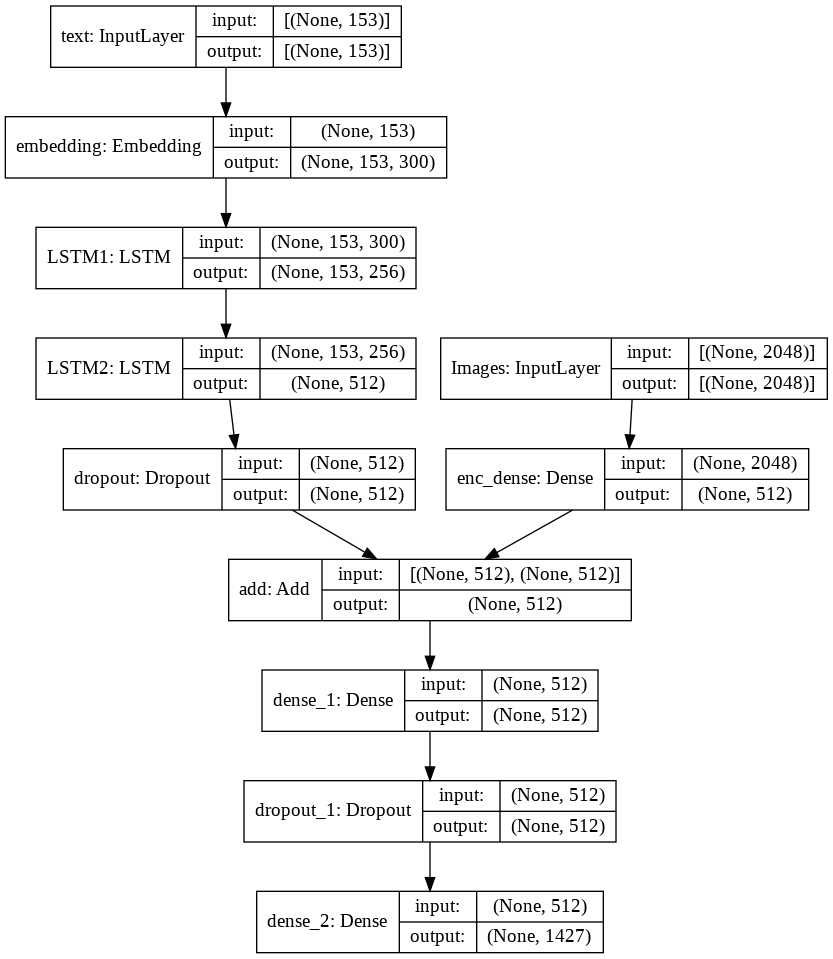

In [42]:

tf.keras.utils.plot_model(encoder_decoder,show_shapes=True,show_layer_names=True,to_file="model1.png")

In [44]:
batch_size=20

In [45]:
#now we prepare the data set with the image fetaures and the reports
train_dataset = tf.data.Dataset.from_tensor_slices((train_features,train_report))
train_dataset = train_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

cv_dataset = tf.data.Dataset.from_tensor_slices((cv_features,cv_report))
cv_dataset = cv_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [46]:
#printing the last batch of train dataset
for element in train_dataset:
  pass
print(element)

(<tf.Tensor: shape=(18, 1, 2048), dtype=float32, numpy=
array([[[5.2882952e-04, 1.8685521e-03, 3.0544184e-03, ...,
         8.0449873e-01, 8.4443432e-01, 6.6292322e-01]],

       [[8.1762912e-05, 1.8834677e-03, 2.5730017e-03, ...,
         8.1255931e-01, 8.2071781e-01, 6.6565961e-01]],

       [[3.8596601e-04, 2.1388598e-03, 2.0403815e-03, ...,
         8.0929083e-01, 8.6978507e-01, 6.5986615e-01]],

       ...,

       [[0.0000000e+00, 1.5021641e-03, 2.4384912e-03, ...,
         8.1386447e-01, 8.0793703e-01, 6.6625512e-01]],

       [[0.0000000e+00, 1.8820933e-03, 1.2643483e-03, ...,
         8.5714698e-01, 8.5290629e-01, 7.0543945e-01]],

       [[4.6175387e-04, 1.7376025e-03, 2.8081902e-03, ...,
         7.9702938e-01, 8.5084629e-01, 6.5484285e-01]]], dtype=float32)>, <tf.Tensor: shape=(18,), dtype=string, numpy=
array([b'SOS no focal lung consolidation .  no pneumothora large pleural effusion .  heart size and pulmonary vascularity are within normal limits .  osseous structures are

In [47]:
'''
Here we load the data to be tained. For each batch from train dataset, we prepare the data like:
for report1, image1 in each batch:
  report is tokenized
  input1= token of <sos>----> 
  output1=<token of next_word in report1>
  image=image1

  input2=token of <sos><token of second word in report1>
  output1=<token of third word>
  image=image1
  .
  .
  .

'''
def load_data(images,reports_unpadded):
    #images=tf.reshape(image,shape=(image.shape[0],image.shape[-1]))
    imgs = []
    input_reports = []
    output_reports = []
    #print(len(images))
    for i in range(len(images)):
      sequence=[] 
      for ele in reports_unpadded[i].split(" "):
        if ele in token.word_index.keys():
          sequence.append(token.word_index[ele])
      #  print(sequence)
      for j in range(1,len(sequence)):

            in_seq = sequence[:j]
            
            
            out_seq = sequence[j]
            
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])
            
            input_reports.append(in_seq)
            
            output_reports.append(out_seq)
        
    return np.array(imgs), np.array(input_reports), np.array(output_reports)

In [48]:
#https://www.tensorflow.org/tutorials/text/nmt_with_attention

loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [49]:
encoder_decoder.compile(optimizer="Adam", loss = maskedLoss)

In [50]:
import datetime
import time

In [53]:
train_loss_list = []
cv_loss_list=[]

for epoch in range(20):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_train = 0
    batch_loss_cv = 0
    
    for img, report in train_dataset:
        
        r1 = [word.decode('utf-8') for word in np.array(report)] # convert the tensor to array and then decode it 

        #for each set of elements in dataset prepare the data using load_data function
        img_input, rep_input, output_word = load_data(img.numpy(), r1)
        #padd the input so as to feed into the model
        rep_input = tf.keras.preprocessing.sequence.pad_sequences(rep_input, maxlen=153, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))
        
        loss = encoder_decoder.train_on_batch([img_input, rep_input], output_word)
        
        batch_loss_train += loss

    train_loss = batch_loss_train/(len(train_report)//20)

    
    
    for img, report in cv_dataset:
        
        r1 = [word.decode('utf-8') for word in np.array(report)]
        img_input, rep_input, output_word = load_data(img.numpy(), r1)
        rep_input = tf.keras.preprocessing.sequence.pad_sequences(rep_input, maxlen=153, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))
        loss = encoder_decoder.test_on_batch([img_input, rep_input], output_word)
        batch_loss_cv += loss
    
    cv_loss = batch_loss_cv/(len(cv_report)//20)
    

    train_loss_list.append(train_loss)

    cv_loss_list.append(cv_loss)
    
    print('Training Loss: {},  Val Loss: {}'.format(train_loss, cv_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
encoder_decoder.save_weights('encoder_decoder_epoch_'+ str(epoch+1) + '.h5')

EPOCH :  1
Training Loss: 0.002047511673342083,  Val Loss: 0.0018462202192663594
Time Taken for this Epoch : 23.63772201538086 sec
EPOCH :  2
Training Loss: 0.0017154356600703113,  Val Loss: 0.001630572701321432
Time Taken for this Epoch : 23.573044776916504 sec
EPOCH :  3
Training Loss: 0.0015208986558081297,  Val Loss: 0.0015081083229570478
Time Taken for this Epoch : 23.685112953186035 sec
EPOCH :  4
Training Loss: 0.0013850780865041553,  Val Loss: 0.0014363909571397085
Time Taken for this Epoch : 23.802019357681274 sec
EPOCH :  5
Training Loss: 0.0012822382871816138,  Val Loss: 0.0013506043275507789
Time Taken for this Epoch : 24.17418670654297 sec
EPOCH :  6
Training Loss: 0.00119540114406102,  Val Loss: 0.0013099938342175275
Time Taken for this Epoch : 24.430248260498047 sec
EPOCH :  7
Training Loss: 0.001124487250421305,  Val Loss: 0.0013017490769184573
Time Taken for this Epoch : 24.055145978927612 sec
EPOCH :  8
Training Loss: 0.0010644472849956393,  Val Loss: 0.00128477611535

In [55]:
encoder_decoder.load_weights('encoder_decoder_epoch_20.h5')

In [56]:
def evaluate(image1,image2):
    #Given the images from test data, we extract the bottleneck features from chexnet model
    image_features = image_feature_extraction(image1,image2)
    output_report=""
    
    #first word for the report is given as <sos>
    inp= "sos"

    image_features=tf.reshape(image_features,shape=(-1,image_features.shape[-1]))
    
    
    
    for i in range(max_len):
        #we find the list of tokens for the input word (already available words)
        list_of_tokens = [token.word_index[w] for w in inp.split()]

        #padd the available tokens to max_len
        input_padded = tf.keras.preprocessing.sequence.pad_sequences([list_of_tokens],max_len, padding='post')
        
        #we pass the image_features and the padded input to the enocoder decoder model and predict the next token
        predictions = encoder_decoder.predict([image_features,input_padded])
        
        #find the corresponding word and attach to the result
        arg = np.argmax(predictions[0]) 
        
        if token.index_word[arg]=="eos":
          
          output_report+=token.index_word[arg]+" "
          break
        else:
            
            output_report+=token.index_word[arg]+" "
            inp+= ' ' + token.index_word[arg]
        
    
    return output_report

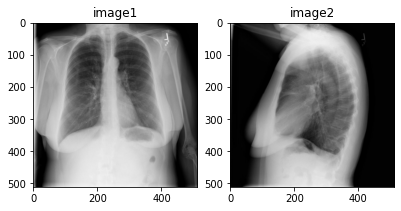

ACTUAL REPORT:  SOS normal heart size and mediastinal contours .  the lungs are hyperinflated but clear .  no pneumothora pleural effusion .  no acute bony abnormalities .  EOS
GENERATED REPORT:  silhouette within normal limits . lungs are clear without focal consolidation pneumothora pleural effusion . bony thora unremarkable . visualized osseous structures the thora are without acute abnormality . no displaced rib fractures identified . no discrete projectile lucency . contrast density within the posterior superficial subcutaneous fat represents projectile shadows . negative for acute bone abnormality . no pneumothora . no acute bony abnormality . no discrete projectile demonstrated . stable degenerative changes the thoracic spine . no acute bony abnormality . no discrete nodule seen . no pneumothora . no pleural effusions . heart size normal . no acute bony abnormalities . degenerative changes the thoracic spine . there deformity the right shoulder . there no fracture dislocation . 

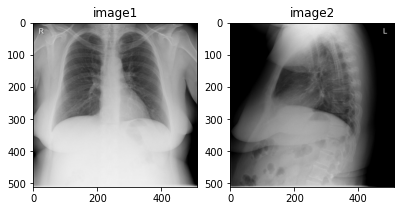

ACTUAL REPORT:  SOS normal heart size and mediastinal contours .  the lungs are free any focal airspace disease .  the left lung base there nodule that not definitively calcified .  no pneumothora pleural effusion .  no acute bony abnormalities .  EOS
GENERATED REPORT:  silhouette and pulmonary vasculature are within normal limits . lungs are clear . no pneumothora pleural effusion . no acute osseous findings . degenerative changes the thoracic spine . no acute displaced rib fractures . no discrete projectile lucency . there mild degenerative changes the thoracic spine . there are mild degenerative changes the spine . there are nonribbearing degenerative changes the thoracic spine . there are no acute bony findings . there are degenerative changes the thoracic spine . there are mild degenerative changes the spine . there are mild degenerative changes the spine . there are no acute bony abnormalities . there no pneumothora . no displaced rib fracture . there are no acute bony abnormalit

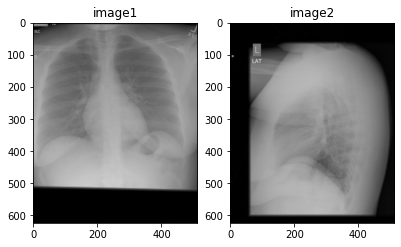

ACTUAL REPORT:  SOS the lungs appear clear .  the heart and pulmonary are normal .  the pleural spaces are clear .  mediastinal contours are normal .  EOS
GENERATED REPORT:  silhouette within normal limits . lungs are clear without focal consolidation pneumothora pleural effusion . bony thora unremarkable . visualized osseous structures the thora are without acute abnormality . no displaced rib fractures identified . no displaced rib fracture . there are degenerative changes the thoracic spine . there are postsurgical clips the right upper quadrant . cholecystectomy . no acute bony abnormalities . soft tissue structures . no pneumothora . no displaced rib fracture . no fracture dislocation . no fracture dislocation . no fracture dislocation . no fracture dislocation . no fracture malalignment . no displaced rib fractures . no displaced rib fractures . no displaced rib fracture . no discrete projectile lucency . no displaced rib fractures . no pneumothora . no displaced rib fractures . 

In [58]:
import random 
index=random.sample(range(Test.shape[0]),3)

for i in index:
  start=time.time()
  img1=Test.iloc[i]["Image-1"]
  img2=Test.iloc[i]["Image-2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  end=time.time()

  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("time taken for evaluation is ",end-start)
  print("*"*100)

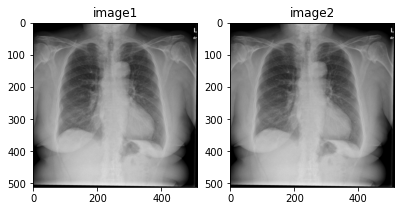

ACTUAL REPORT:  SOS chest .  the heart and lungs have the interval .  both lungs are clear and epanded .  heart and mediastinum normal .  left knee .  the right total knee prosthesis remains the medial compartment markedly narrow .  large osteophytes are present the left femur and tibial lateral plateaus .  EOS
GENERATED REPORT:  silhouette and pulmonary vasculature are within normal limits . lungs are clear . no pneumothora pleural effusion . no acute osseous findings . degenerative changes the thoracic spine . no acute displaced rib fractures . no displaced rib fractures . soft tissues grossly unremarkable . there are degenerative changes the spine . there are nonribbearing marginal degenerative changes . there no layering . there are degenerative changes the thoracic spine . there no pneumothora . there no large pleural effusion . there no evidence displaced rib fracture . there no evidence for displaced rib fractures . there are degenerative changes the spine . there are etensive p

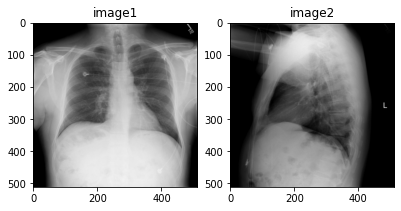

ACTUAL REPORT:  SOS the heart normal size and contour .  the lungs are clear without evidence infiltrate .  there no pneumothora effusion .  EOS
GENERATED REPORT:  silhouette within normal limits . lungs are clear without focal consolidation pneumothora pleural effusion . bony thora unremarkable . no acute bony abnormality identified . the soft tissues unremarkable . normal heart size . normal pulmonary vascularity . bony structures are intact . no pneumothora . no displaced fracture . no fracture dislocation . no fracture dislocation . no fracture dislocation . no fracture dislocation . no fracture dislocation . no fracture dislocation . no clavicle . no displaced rib fractures . soft tissues and soft tissues are unremarkable . normal heart size . normal pulmonary vascularity . bony structures are intact . no pneumothora . no displaced rib fractures . no fracture dislocation . no fracture dislocation . no fracture dislocation . no fracture dislocation . no fracture dislocation . no fr

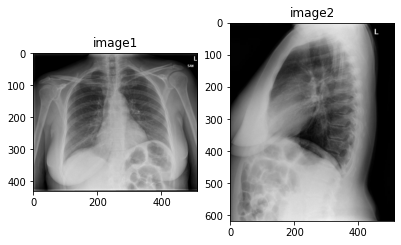

ACTUAL REPORT:  SOS no pleural effusion no pneumothora .  normal cardiac contour .  no focal consolidation .  lungs clear bilaterally .  EOS
GENERATED REPORT:  silhouette within normal limits . lungs are clear without focal consolidation pneumothora pleural effusion . bony thora unremarkable . visualized osseous structures the thora are without acute abnormality . no displaced rib fractures identified . no displaced rib fracture . there are degenerative changes the thoracic spine . there are postsurgical changes the left shoulder . no acute bony abnormalities . no displaced fracture . no discrete projectile lucency . there are degenerative changes the thoracic spine . there no suprapatellar . there no displaced fracture . there mild degenerative changes the thoracic spine . there no pneumothora . there are mild degenerative changes the spine . there no suprapatellar . there no large effusion . no displaced rib fractures . there are degenerative changes the spine . there no suprapatella

In [60]:
import random 
index=random.sample(range(Test.shape[0]),3)

for i in index:
  start=time.time()
  img1=Test.iloc[i]["Image-1"]
  img2=Test.iloc[i]["Image-2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  end=time.time()

  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("time taken for evaluation is ",end-start)
  print("*"*100)

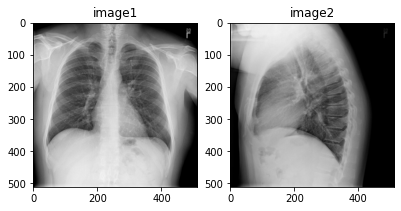

ACTUAL REPORT:  SOS cardiomediastinal silhouette and pulmonary vasculature are within normal limits .  lungs are clear .  no pneumothora pleural effusion .  no radiodense foreign bodies noted .  no acute osseous findings .  EOS
GENERATED REPORT:  silhouette within normal limits . lungs are clear without focal consolidation pneumothora pleural effusion . bony thora unremarkable . no acute bony abnormality identified . the soft tissues unremarkable . normal heart size . normal pulmonary vascularity . bony structures are intact . no pneumothora . no displaced fracture . there mild degenerative changes the thoracic spine . there no for obstruction obstruction dislocation . there no evidence for skeletal bony structures are unremarkable . there no suprapatellar . there no fracture malalignment . there no fracture malalignment . there no fracture malalignment . there no fracture malalignment . there no fracture dislocation . there no fracture dislocation . there no fracture dislocation . the

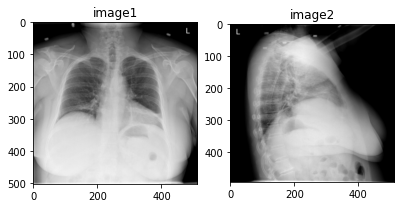

ACTUAL REPORT:  SOS the heart pulmonary and mediastinum are within normal limits .  there no pleural effusion pneumothora .  there bilateral basilar opacity compatible with atelectasis .  there are somewhat low lung volumes .  there calcified right hilar lymph node .  EOS
GENERATED REPORT:  silhouette and pulmonary vasculature are within normal limits . lungs are clear . no pneumothora pleural effusion . no acute osseous findings . degenerative changes the thoracic spine . there deformity the midthoracic junction . degenerative changes the thoracic spine . there are postsurgical changes the left shoulder . no acute bony abnormalities . no displaced fracture . there deformity the midthoracic junction the cervicothoracic the lateral view . there etensive the bowel pattern well well seen prior eam . there no evidence for displaced rib fracture . there no evidence pneumothora . there are degenerative changes the spine . there no evidence for obstruction obstruction infiltrate . there no pn

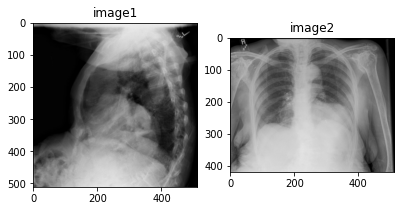

ACTUAL REPORT:  SOS the lungs and pleural spaces show no acute abnormality .  heart size enlarged pulmonary vascularity within normal limits .  marked tortuosity the thoracic aorta .  there are advanced degenerative changes the glenohumeral joints bilaterally with boneonbone articulation remodeling the glenoid and etensive subchondral cystic change .  no displaced rib fractures are visualized .  diffuse osteopenia the thoracic spine with mid thoracic and several lower thoracic deformities ageindeterminate .  there airfluid level the middle mediastinum most secondary large hiatal hernia .  EOS
GENERATED REPORT:  and lateral views the chest were obtained . the cardiomediastinal silhouette normal size and configuration . the lungs are well aerated . there no pneumothora pleural effusion focal air space consolidation . degenerative spine . no acute bony abnormality . there deformity the right shoulder . there no fracture malalignment . there are degenerative changes the spine . there are e

In [61]:
import random 
index=random.sample(range(Test.shape[0]),3)

for i in index:
  start=time.time()
  img1=Test.iloc[i]["Image-1"]
  img2=Test.iloc[i]["Image-2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  end=time.time()

  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("time taken for evaluation is ",end-start)
  print("*"*100)